# fastText chABSA dataset slot 3 evaluation with word embeddings

Cross validated.

## Polarity classification

    F1 is 0.77924

In [ ]:
! git clone https://github.com/daisukelab/dl-cliche.git
! cd dl-cliche && pip install .
! rm -fr dl-cliche

In [ ]:
# Download dataset & stop_words_ja.txt
! wget https://s3-ap-northeast-1.amazonaws.com/dev.tech-sketch.jp/chakki/public/chABSA-dataset.zip
! unzip -q chABSA-dataset.zip && rm chABSA-dataset.zip && rm -r __MACOSX
! ls chABSA-dataset
! cd chABSA-dataset && wget https://raw.githubusercontent.com/chakki-works/chABSA-dataset/master/notebooks/resource/stop_words_ja.txt

In [1]:
from dlcliche.utils import *
from dlcliche.nlp_mecab import *

In [2]:
DATA = Path('chABSA-dataset')

def check_data_existence(folder):
    file_count = len(list(folder.glob("e*_ann.json")))
    if  file_count == 0:
        raise Exception("Processed Data does not exist.")
    else:
        print("{} files ready.".format(file_count))

check_data_existence(DATA)

stop_words = []
with (DATA/"stop_words_ja.txt").open(encoding="utf-8") as f:
    stop_words = f.readlines()
    stop_words = [w.strip() for w in stop_words]

print("{} stop words ready.".format(len(stop_words)))

230 files ready.
310 stop words ready.


In [3]:
label_kinds = []

# make labels (exclude NULL and OOD)
for e in ["market", "company", "business", "product"]:
    for a in ["general", "sales", "profit", "amount", "price", "cost"]:
        label_kinds.append(e + "#" + a)
        if e in ["market"]:
            break;

print(label_kinds)

['market#general', 'company#general', 'company#sales', 'company#profit', 'company#amount', 'company#price', 'company#cost', 'business#general', 'business#sales', 'business#profit', 'business#amount', 'business#price', 'business#cost', 'product#general', 'product#sales', 'product#profit', 'product#amount', 'product#price', 'product#cost']


In [6]:
import json
import numpy as np
import pandas as pd
from collections import Counter

sentences = []
dataset = []
labels = []   
tokenizer = get_mecab_tokenizer(stop_words=stop_words, normalize=False)

for f in DATA.glob("e*_ann.json"):
    with f.open(encoding="utf-8") as j:
        d = json.load(j)
        for s in d["sentences"]:
            tokenized = tokenizer.tokenize(s["sentence"].lower())
            for o in s["opinions"]:
                if o["category"] in label_kinds:
                    # sentence index + category
                    dataset.append((len(sentences), o["category"]))
                    labels.append(o["polarity"])
            sentences.append(tokenized)

In [7]:
print(sentences[dataset[0][0]])
print("category is {}, polarity is {}".format(dataset[0][1], labels[0]))

['この', 'な', '状況', 'における', '、', '当社', 'グループ', 'の', '売上', 'は', '、', '国内', 'について', 'は', '、', 'しょうゆ', '、', '飲料', 'が', '堅調', 'に', '推移', 'し', '、', '食品', '、', '酒類', 'が', '前期', 'を', '下回っ', 'た', 'ものの', '、', '全体', 'として', 'ほぼ', '前期', '並み', 'と', 'なり', 'た']
category is product#general, polarity is positive


In [8]:
if len(sentences) != len(labels) != len(dataset):
    raise Exception("sentence and label count does not match!")

print("{} data is available.".format(len(labels)))

2646 data is available.


## fastText model for getting word embeddings

Text embedding is calculated as mean of BOW.

In [9]:
import gensim

PATH = Path('/mnt/dataset/nlp/wikipedia')
ftmodel = gensim.models.KeyedVectors.load_word2vec_format(str(PATH/'all_asis_ja.vec'), binary=False)

vec_sz = 300

def get_text_embeddings(model, tokens):
    def _vector(w):
        return model[w] if w in model.wv.vocab else np.zeros_like(ftmodel[ftmodel.wv.index2word[1000]])
    return np.array([_vector(w) for w in tokens]).mean(axis=0)

In [10]:
num_words = np.sum([len(s) for s in sentences])
num_unk   = int(np.sum([np.sum([w in ftmodel.wv.vocab for w in s]) for s in sentences]))
print(f'With all {num_words} words, {num_unk} are unknown. Only {num_words-num_unk} are valid vectors...')

With all 212379 words, 210509 are unknown. Only 1870 are valid vectors...


In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline

class SentenceToLMVec(BaseEstimator, TransformerMixin):
    
    def __init__(self, corpus, label_kinds, vector_len=1000):
        self.corpus = corpus
        self.vocab = []
        self.label_kinds = label_kinds
        self.vector_len = vector_len
    
    def fit(self, X, y=None):
        # do nothing
        return self

    def _vectorize(self, words_and_index):
        words = words_and_index[0]
        index = words_and_index[1]
        vector = get_text_embeddings(ftmodel, words)
        return np.hstack([vector, [index/len(self.label_kinds)]])

    def transform(self, X, copy=True):
        expand = lambda _x: (self.corpus[int(_x[0])], self.label_kinds.index(str(_x[1])))
        _X =  np.apply_along_axis(expand, 1, X)
        tX = np.zeros((_X.shape[0], vec_sz + 1))
        for i in range(_X.shape[0]):
            tX[i] = self._vectorize(_X[i])
        return tX

model = Pipeline([("vectorize", SentenceToLMVec(sentences, label_kinds)), ("clf", OneVsRestClassifier(LinearSVC(random_state=0)))])

['2' 'product#general']
[learning_curve] Training set sizes: [ 211  687 1163 1639 2116]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ....................... , score=0.7169811320754716, total=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  ................................................................
[CV] ....................... , score=0.7716981132075472, total=   0.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  ................................................................
[CV] ....................... , score=0.7660377358490567, total=   0.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s


[CV]  ................................................................
[CV] ....................... , score=0.7773584905660378, total=   0.6s
[CV]  ................................................................
[CV] ....................... , score=0.7754716981132076, total=   0.7s
[CV]  ................................................................
[CV] ....................... , score=0.7471698113207547, total=   0.1s
[CV]  ................................................................
[CV] ........................ , score=0.769811320754717, total=   0.3s
[CV]  ................................................................
[CV] ....................... , score=0.7641509433962265, total=   0.4s
[CV]  ................................................................
[CV] ....................... , score=0.7566037735849057, total=   0.5s
[CV]  ................................................................
[CV] ....................... , score=0.7509433962264151, total=   0.7s
[CV]  

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   22.0s finished


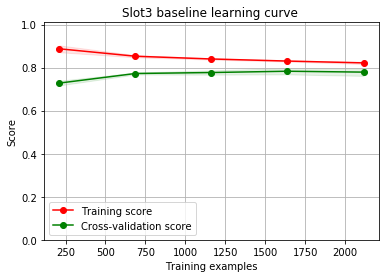

In [12]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit


# learning curve function
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(
        estimator, title, X, y, ylim=None, cv=None,
        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), verbose=0):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

X = np.array(dataset)
y = np.array(labels)

print(X[0])

plot_learning_curve(model, "Slot3 baseline learning curve ",
                    X, labels, ylim=(0.0, 1.01), cv=cv, n_jobs=1, verbose=4)

plt.show()

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

f1 = []

for train_index, test_index in cv.split(X):
    model.fit(X[train_index, :], y[train_index])
    y_pred = model.predict(X[test_index, :])
    y_true = y[test_index]
    micro_f1 = f1_score(y_true, y_pred, average="micro")
    f1.append(micro_f1)

print("F1 is {} (+/-{})".format(np.mean(f1), np.std(f1)))

F1 is 0.778867924528302 (+/-0.01747296136270222)


In [14]:
from sklearn.metrics import precision_recall_fscore_support

digits = 5
f1 = []
for train_index, test_index in cv.split(X):
    model.fit(X[train_index, :], y[train_index])
    y_pred = model.predict(X[test_index, :])
    y_true = y[test_index]
    p, r, _, _ = precision_recall_fscore_support(y_true, y_pred, average="micro")
    p, r = np.round(p, digits + 1),  np.round(r, digits + 1)
    _f1 = np.round(2 * p * r / ( p + r), digits)
    f1.append(_f1)

print("F1 is {}".format(np.median(f1)))

F1 is 0.77924
